1. Explore Label Data

In [7]:
#imports

import os
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
import cv2

import mediapipe as mp
import csv

In [8]:

# counting summary aspects of data

video_data = os.listdir('..\\data_scraping\\Web_Scrape_Labeled_2\\')
video_data = video_data + os.listdir('..\\data_supplement\\Self_Record_Labeled\\')
# print(video_data)

o_counter = 0
f_counter = 0
b_counter = 0
s_counter = 0
l_counter = 0

left_counter = 0
NUM_FILES = 76

for filename in video_data:
    o_counter += int(filename[4])
    f_counter += int(filename[7])
    b_counter += int(filename[10])
    s_counter += int(filename[13])
    l_counter += int(filename[16])
    if (filename[18] == 'L'): 
        left_counter += 1
    
    # making sure labels are OK after averages
    if (int(filename[7]) > 0 and int(filename[10]) > 0):
        print('Review ' + str(filename))

left_counter = float(left_counter) / (float(NUM_FILES))
left_counter *= 100


L entrances: 219.737%
R entrances: -119.737%

Sums of all ratings: 
overstride: 795
forward lean: 393
backward lean: 620
sweeping: 1238
low arms: 644


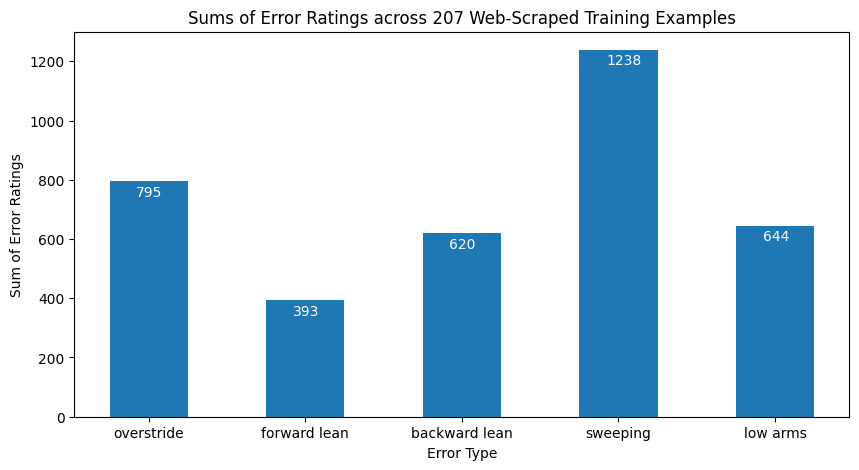

In [9]:
# displaying summative data information

print('L entrances: ' + str(round(left_counter, 3)) + '%')
print('R entrances: ' + str(round(100 - left_counter, 3)) + '%\n')

print('Sums of all ratings: ')
print('overstride: ' + str(o_counter))
print('forward lean: ' + str(f_counter))
print('backward lean: ' + str(b_counter))
print('sweeping: ' + str(s_counter))
print('low arms: ' + str(l_counter))

errors = ['overstride', 'forward lean', 'backward lean', 'sweeping', 'low arms']
rating_sums = [o_counter, f_counter, b_counter, s_counter, l_counter]

fig = plt.figure(figsize=(10, 5))

plt.bar(errors, rating_sums, width = 0.5)
plt.xlabel('Error Type')
plt.ylabel('Sum of Error Ratings')
plt.title('Sums of Error Ratings across 207 Web-Scraped Training Examples')    

for index, value in enumerate(rating_sums):
    plt.text(index - 0.08, value -50, str(value), color='white') # add annotations

plt.show()

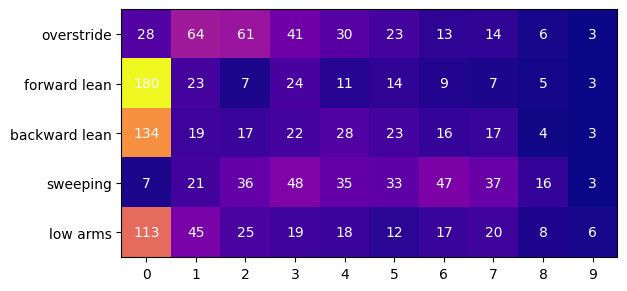

In [10]:
ratings = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

type_count = np.zeros((5, 10), dtype=int)

for filename in video_data:
    type_count[0][int(filename[4])] += 1
    type_count[1][int(filename[7])] += 1
    type_count[2][int(filename[10])] += 1
    type_count[3][int(filename[13])] += 1
    type_count[4][int(filename[16])] += 1

# print(type_count)



fig, ax = plt.subplots()
im = ax.imshow(type_count, cmap='plasma')

ax.set_xticks(np.arange(len(ratings)))
ax.set_yticks(np.arange(len(errors)))
ax.set_xticklabels(ratings)
ax.set_yticklabels(errors)

for i in range(len(errors)):
    for j in range(len(ratings)):
        text = ax.text(j, i, type_count[i, j], ha="center", va="center", color="white")

plt.show()

2. Use MoveNet to Estimate Pose

In [11]:
# visualizing keypoints
def draw_keypoints(frame, keypoints, min_confidence):
    y, x, c = frame.shape
    print ('height: ' + str(y) + ' width: ' + str(x))
    print('KEYPOINTS:')
    print(keypoints)
    shaped = np.squeeze(np.multiply(keypoints, [1, 1, 1]))

    print(shaped[0])

    for kp in shaped:
        ky, kx, conf = kp
        print('KY, KX, CONF: ' + str(int(ky * y)) + ' ' +  str(int(kx * x)) + ' ' + str(conf))
        if conf > min_confidence:
            cv2.circle(frame, (int(kx * x), int(ky * y)), 5, (255, 0, 0), -1)

In [12]:
# pose estimation with MoveNet
# MEDIAPIPE (BELOW) GIVES BETTER RESULTS, SO MOVENET IS NOT USED

interpreter = tf.lite.Interpreter(model_path='lite-model_movenet_singlepose_thunder_tflite_float16_4.tflite')
interpreter.allocate_tensors()

filename = '..\\data_scraping\\Web_Scrape_Labeled_2\\ -- .mp4'

cap = cv2.VideoCapture(filename)

while (cap.isOpened()):
    ret, frame = cap.read()

    red = frame[:,:,2].copy()
    blue = frame[:,:,0].copy()
    frame[:,:,2] = blue
    frame[:,:,0] = red

    if ret:
    
        # reshape image
        img = frame.copy()
        img = tf.image.resize_with_pad(np.expand_dims(img, axis=0), 256,256)
        input_image = tf.cast(img, dtype=tf.uint8) # change base on lightning/thunder float32/uint8
        
        # set up input / output
        input_details = interpreter.get_input_details()
        output_details = interpreter.get_output_details()

        # make prediction
        interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
        interpreter.invoke()
        points_with_scores = interpreter.get_tensor(output_details[0]['index'])

        print(points_with_scores)

        # display prediction
        square_img = np.array(tf.cast(np.squeeze(img), dtype=tf.uint8))

        square_frame = tf.image.resize_with_pad(np.expand_dims(frame, axis=0), 1280,1280)
        square_frame = np.array(tf.cast(np.squeeze(square_frame), dtype=tf.uint8))


        draw_keypoints(square_frame, points_with_scores, 0.1)  
        
        plt.figure(figsize=(20,20))
        plt.imshow(square_frame) # display only

        cap.release()     
    
    else:
        break

cap.release()

    

3. Use MediaPipe to Estimate Pose

In [30]:
# helper function for data formatting

def mediapipe_to_series(series, landmarks):

    landmark_index = 0

    for key in series:
        if (key[-1] == 'x'): 
            series[key].append(landmarks[landmark_index].x)
        elif (key[-1] == 'y'):
            series[key].append(landmarks[landmark_index].y)
        elif (key[-1] == 'z'):
            series[key].append(landmarks[landmark_index].z)
        else:
            series[key].append(landmarks[landmark_index].visibility)
            landmark_index += 1

    return series


In [45]:
# MEDIAPIPE PERFORMS BETTER THAN MOVENET

mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

ws_filepath = '..\\data_scraping\\Web_Scrape_Labeled_2\\'
sr_filepath = '..\\data_supplement\\Self_Record_Labeled\\'

web_scrape_videos = os.listdir(ws_filepath)
self_record_videos = os.listdir(sr_filepath)


for ws_video in web_scrape_videos:

    filepath = ws_filepath + ws_video
    cap = cv2.VideoCapture(filepath)
    frame_rate = cap.get(cv2.CAP_PROP_FPS)
    h = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
    w = cap.get(cv2.CAP_PROP_FRAME_WIDTH)

    print ('h: ' + str(h) + ' w: ' + str(w))
    size = (int(w), int(h))

    series = {
            'left_shoulder_x' : [], 'left_shoulder_y' : [], 'left_shoulder_z' : [], 'left_shoulder_v' : [],
            'right_shoulder_x' : [], 'right_shoulder_y' : [], 'right_shoulder_z' : [], 'right_shoulder_v' : [],
            'left_elbow_x' : [], 'left_elbow_y' : [], 'left_elbow_z' : [], 'left_elbow_v' : [],
            'right_elbow_x' : [], 'right_elbow_y' : [], 'right_elbow_z' : [], 'right_elbow_v' : [],
            'left_wrist_x' : [], 'left_wrist_y' : [], 'left_wrist_z' : [], 'left_wrist_v' : [],
            'right_wrist_x' : [], 'right_wrist_y' : [], 'right_wrist_z' : [], 'right_wrist_v' : [],
            'left_hip_x' : [], 'left_hip_y' : [], 'left_hip_z' : [], 'left_hip_v' : [],
            'right_hip_x' : [], 'right_hip_y' : [], 'right_hip_z' : [], 'right_hip_v' : [],
            'left_knee_x' : [], 'left_knee_y' : [], 'left_knee_z' : [], 'left_knee_v' : [],
            'right_knee_x' : [], 'right_knee_y' : [], 'right_knee_z' : [], 'right_knee_v' : [],
            'left_ankle_x' : [], 'left_ankle_y' : [], 'left_ankle_z' : [], 'left_ankle_v' : [],
            'right_ankle_x' : [], 'right_ankle_y' : [], 'right_ankle_z' : [], 'right_ankle_v' : [],
            'left_heel_x' : [], 'left_heel_y' : [], 'left_heel_z' : [], 'left_heel_v' : [],
            'right_heel_x' : [], 'right_heel_y' : [], 'right_heel_z' : [], 'right_heel_v' : [],
            'left_foot_index_x' : [], 'left_foot_index_y' : [], 'left_foot_index_z' : [], 'left_foot_index_v' : [],
            'right_foot_index_x' : [], 'right_foot_index_y' : [], 'right_foot_index_z' : [], 'right_foot_index_v' : []
        }
    
    pose_img_video = cv2.VideoWriter('..\\time_series\\pose_videos\\' + str(ws_video), cv2.VideoWriter_fourcc(*'h264'), frame_rate, size)

    with mp_pose.Pose(min_detection_confidence=0.1, min_tracking_confidence=0.1) as pose:
        while(cap.isOpened()):
            ret, frame = cap.read()
            if ret:

                # convert color space for model
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
                image.flags.writeable = False

                # invoke MediaPipe pose estimation
                results = pose.process(image)
                # print(results)

                # extract landmark coordinates
                try:
                    landmarks = results.pose_landmarks.landmark
                except:
                    pass
                # print(landmarks)

                series = mediapipe_to_series(series, landmarks)
                # print(series)

                # visualize pose estimate
                image.flags.writeable = True
                mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  
                pose_img_video.write(image)
                # plt.figure(figsize=(20,20))
                # plt.imshow(image)

            else:
                # save video and csv
                pose_img_video.release()
                cap.release()

                np.save('..\\time_series\\web_scrape\\' + os.path.splitext(ws_video)[0], series)
                break

    print ('completed ' + ws_video)

    


h: 720.0 w: 1280.0
completed WS-O0-F0-B0-S2-L0-L-0002.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B1-S7-L0-L-0001.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B3-S5-L0-L-0027.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B4-S2-L1-L-0026.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B4-S3-L0-L-0037.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B5-S6-L7-L-0048.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B5-S6-L7-R-0045.mp4
h: 720.0 w: 1280.0
completed WS-O0-F0-B6-S3-L5-L-0042.mp4
h: 720.0 w: 1280.0
completed WS-O0-F1-B0-S6-L0-L-0000.mp4
h: 720.0 w: 1280.0
completed WS-O0-F4-B0-S3-L0-L-0003.mp4
h: 720.0 w: 1280.0
completed WS-O0-F5-B0-S3-L0-R-0011.mp4
h: 1080.0 w: 1920.0
completed WS-O0-F7-B0-S1-L2-L-0061.mp4
h: 360.0 w: 480.0
completed WS-O0-F8-B0-S7-L9-R-0063.mp4
h: 720.0 w: 1280.0
completed WS-O1-F0-B0-S1-L0-R-0068.mp4
h: 720.0 w: 1280.0
completed WS-O1-F0-B0-S3-L0-L-0131.mp4
h: 720.0 w: 1280.0
completed WS-O1-F0-B0-S4-L0-L-0008.mp4
h: 720.0 w: 1280.0
completed WS-O1-F0-B0-S5-L0-L-0016.mp4
h: 720.0 w: 12